# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:

- Use sampling techniques to address a class imbalance problem within a dataset 
- Create a visualization of ROC curves and use it to assess a model

## Predicting credit card fraud


The following cell loads all the functions you will be using in this lab. All you need to do is run it: 

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/orin/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files. 

In [2]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz', compression='gzip')

# Print the first five rows of data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [7]:
# Count the number of fraudulent/infraudulent purchases
print(df.Class.value_counts())    

0    284315
1       492
Name: Class, dtype: int64


## Define the predictor and target variables

Define `X` and `y` and perform a standard train-test split. Assign 25% to the test set and `random_state` to 0. 

In [8]:
# Your code here
y = df.Class
X = df.drop(columns=['Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Find the class imbalance in the training and test sets: 

In [9]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    213233
1       372
Name: Class, dtype: int64


0    71082
1      120
Name: Class, dtype: int64


## Create an initial model

As a baseline, train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

AUC: 0.8841414375885128


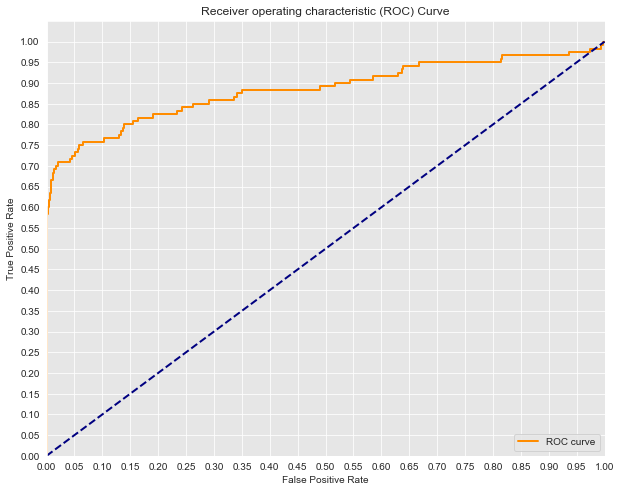

In [10]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Here is the function to plot a confusion matrix you defined in an earlier lesson. Use it to plot the confusion matrix of the test set: 

In [18]:
# Plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[71026    53]
 [   56    67]]


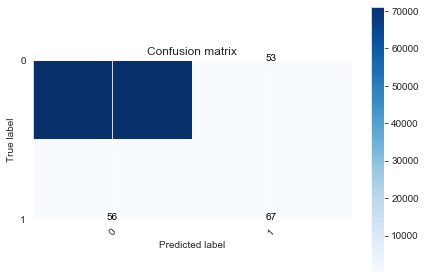

In [19]:
# Plot confusion matrix of the test set 
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

## Tune the model 

Try some of the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.8397641690817178
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.8817812526377986
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
         

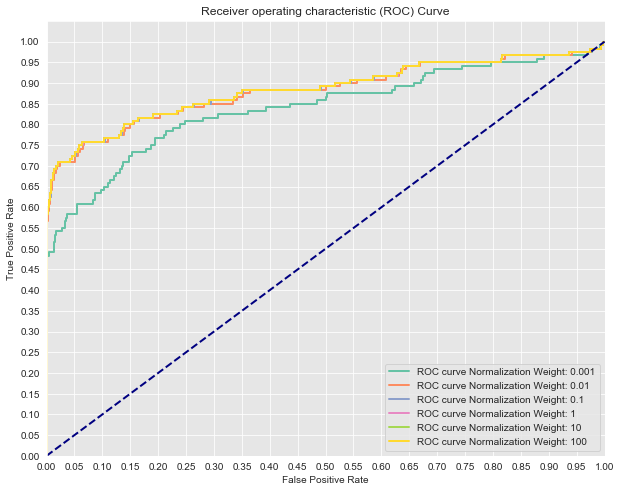

In [21]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class. 

In [23]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    213233
1       372
Name: Class, dtype: int64


1    213233
0    213233
dtype: int64


Similar to what you did above, build models with this resampled training data: 

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.9636310880391661
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9636115097117883
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

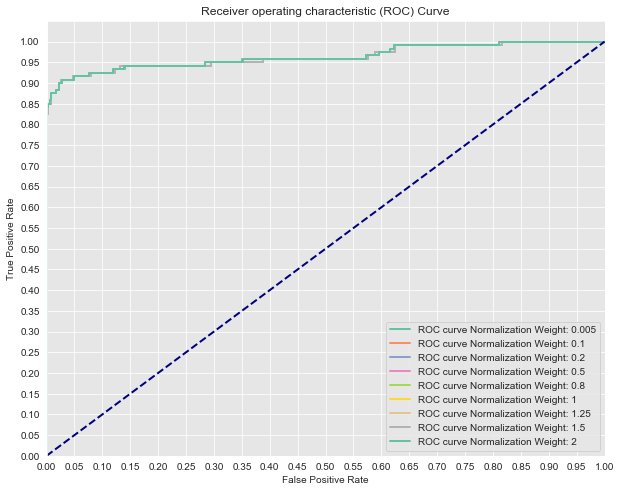

In [24]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
---------------------------------
1    284315
0    284315
dtype: int64
----------------------------------------------
AUC for 0.005: 0.9907311038269219
----------------------------------------------
AUC for 0.1: 0.9907287381129166
----------------------------------------------
AUC for 0.2: 0.9907288065982784
----------------------------------------------
AUC for 0.3: 0.9907288246103245
----------------------------------------------
AUC for 0.5: 0.9907288416326977
----------------------------------------------
AUC for 0.6: 0.9907288517273609
----------------------------------------------
AUC for 0.7: 0.9907288546963795
----------------------------------------------
AUC for 0.8: 0.9907288604364821


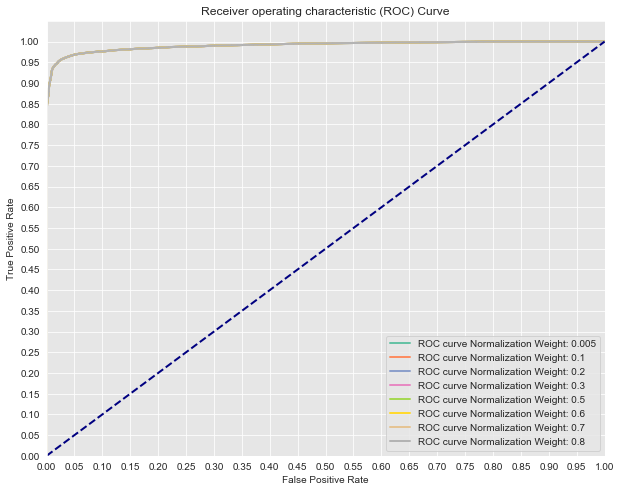

In [25]:
# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Your response here

In [ ]:
# The ROC curve looks like this because we also manipulated the test set with SMOTE (synthetic minority oversampling).
# this produces results that can't properly be compared to future cases as we have synthetically created test cases. SMOTE should
# only be applied to training sets. From that, we can more accurately gauges the model's performance by using original test samples.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.